In [1]:
from model.param import params
import librosa

In [2]:
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import scipy as sp
import soundfile as sf
import wavio
from tqdm import tqdm
import numpy.matlib as matlib
from keras import optimizers

In [4]:
# metadata_file_names = []
# metadata_labels = []

# for i in range(10):
#     add_path = 'audio/class{:02d}'.format(i)
#     class_path = os.path.join(params.data_dir, add_path)
#     search_keyword = os.path.join(class_path, '*.wav')
#     path_list = glob(search_keyword)
#     file_names = [path.split('\\')[-1] for path in path_list]
#     labels = i * np.ones(len(file_names), dtype=np.int8)
    
#     metadata_file_names.extend(file_names)
#     metadata_labels.extend(labels)
    

In [5]:
meta_path = os.path.join(params.data_dir, params.meta_file)

# with open(meta_path, 'w') as f:
#     for i in range(len(metadata_file_names)):
#         f.write('{:s}|{:d}\n'.format(metadata_file_names[i], metadata_labels[i])) 

In [6]:
wav_file_names = []
labels = []

with open(meta_path, 'r') as meta_data:
    for line in meta_data:
        wav_file_name, label = line.strip().split('|')
        wav_file_names.append(wav_file_name)
        labels.append(int(label))
        
wav_file_names_tensor = tf.convert_to_tensor(wav_file_names)
labels = tf.one_hot(labels, 10)
labels_tensor = tf.convert_to_tensor(labels)

In [7]:
# for i, wav_file_name in enumerate(wav_file_names):
#     file_path = os.path.join(params.data_dir, wav_file_name)  
#     try:
#         y, fs = librosa.core.load(file_path, dtype=np.float32, mono=True)
#         print('{:04d}'.format(i))
#     except:
#         print("Unexpected error:", sys.exc_info()[0])

In [8]:
labels_tensor.set_shape((None, 10))

In [9]:
labels_tensor

<tf.Tensor 'one_hot:0' shape=(8732, 10) dtype=float32>

In [10]:
wav_file_names_tensor

<tf.Tensor 'Const:0' shape=(8732,) dtype=string>

In [11]:
num_epochs = 1

In [12]:
# Create Queues
dataset = tf.data.Dataset.from_tensor_slices(tuple([wav_file_names_tensor, labels_tensor])).shuffle(wav_file_names_tensor.shape[0]).repeat(num_epochs)

In [13]:
dataset.batch(32)

<BatchDataset shapes: ((?,), (?, 10)), types: (tf.string, tf.float32)>

In [14]:
def load_wav_file(wav_file_name):
    file_path = os.path.join(params.data_dir, wav_file_name.decode("utf-8"))   
    y, fs = librosa.core.load(file_path, dtype=np.float32, mono=True)
    y = y.astype(np.float32)
    fs = np.int32(fs)
    return y, fs

In [15]:
def spectrogram(wav, nsc, nov):
    
    
    S = librosa.core.stft(wav, n_fft=nsc, hop_length=(nsc - nov))
    Sxx = abs(S)
    dbS = 20 * np.log10(np.maximum(Sxx, params.eps))
    
    
    return dbS

In [16]:
def spectrogram_wrapper(wav_file_name):
    
    y, fs = load_wav_file(wav_file_name)
    
    nsc = int(fs * params.nsc_sec)
    nov = int(fs * params.nov_sec)
    
    Sxx = spectrogram(y, nsc, nov)
    
    if Sxx.shape[1] < params.minimum_width:
        repeat = int(np.ceil(params.minimum_width / Sxx.shape[1]))
        Sxx = matlib.repmat(Sxx, 1, repeat)[:, :params.minimum_width]
    
    print('working')
    
    return Sxx
    

In [17]:
dataset = dataset.batch(32)

In [18]:
iterator = dataset.make_one_shot_iterator()
wav_file, label = iterator.get_next()

In [19]:
wav_file

<tf.Tensor 'IteratorGetNext:0' shape=(?,) dtype=string>

In [20]:
with tf.Session() as sess:
    xx = sess.run(wav_file)
    print(xx[0].decode())

159755-8-0-1.wav


In [21]:
y, fs = tf.py_func(load_wav_file, [wav_file[0]], [tf.float32, tf.int32])

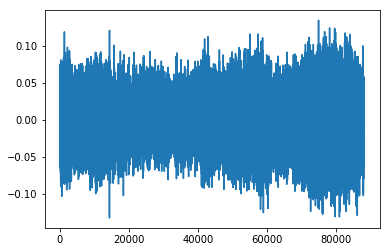

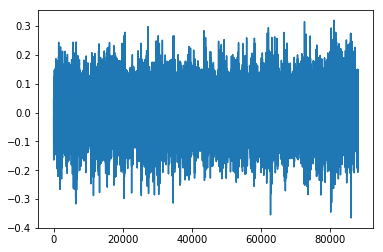

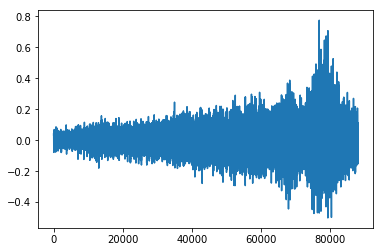

In [22]:
with tf.Session() as sess:    
    for i in range(3):
        Y, FS = sess.run([y, fs])
        plt.plot(Y)
        plt.show()

In [23]:
Sxx = tf.py_func(spectrogram_wrapper, [wav_file[0]], [tf.float32])

working


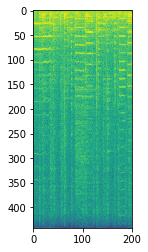

In [24]:
with tf.Session() as sess:
    xx = sess.run(Sxx)
    plt.imshow(xx[0])

In [25]:
Sxx_tensor = tf.convert_to_tensor(Sxx)

In [26]:
with tf.Session() as sess:
    xx = sess.run(Sxx_tensor)
    print(xx.shape)

working
(1, 442, 201)


In [27]:
Sxx_tensor = tf.expand_dims(Sxx_tensor, axis=-1)

In [28]:
with tf.Session() as sess:
    xx = sess.run(Sxx_tensor)
    print(xx.shape)

working
(1, 442, 201, 1)


In [29]:
Sxx_tensor.set_shape([None, None, None, None])

In [30]:
with tf.Session() as sess:
    xx = sess.run(Sxx_tensor)
    print(xx.shape)

working
(1, 442, 201, 1)


In [31]:
model_vgg19 = VGG19(include_top=True, weights=None, input_tensor=Sxx_tensor, input_shape=[442, 201, 1], pooling=None, classes=10)

In [32]:
with tf.Session() as sess:
    xx = sess.run(label)
    print(xx)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0.

In [33]:
label = tf.reshape(label, [-1, 10])

In [34]:
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)


model_vgg19.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              target_tensors=[label])

In [37]:
model_vgg19.fit(steps_per_epoch=1, epochs=5,  verbose=1)

Epoch 1/5
working


ResourceExhaustedError: OOM when allocating tensor with shape[4096,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/mul_172}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/sub_104, training/Adam/gradients/fc2/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


working
(442, 201)


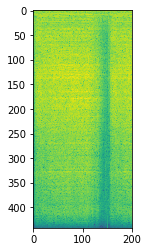

working
(442, 201)


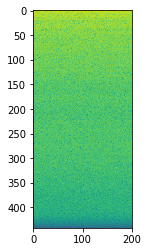

working
(442, 201)


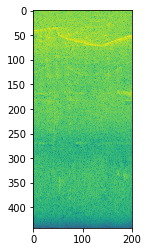

working
(442, 201)


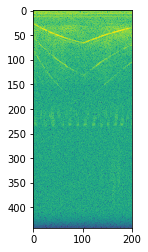

working
(442, 201)


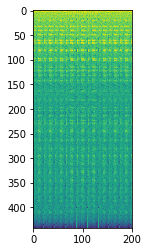

working
(442, 201)


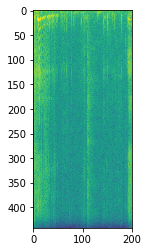

working
(442, 201)


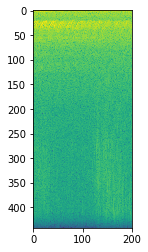

working
(442, 201)


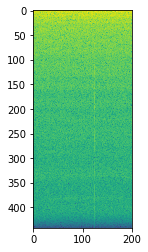

working
(442, 201)


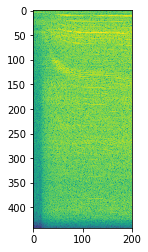

working
(442, 201)


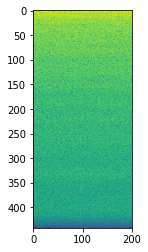

working
(442, 201)


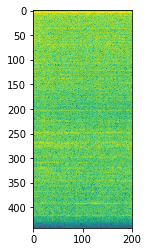

working
(442, 201)


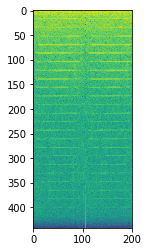

working
(442, 201)


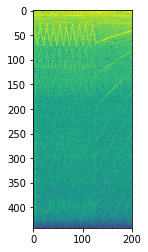

working
(442, 201)


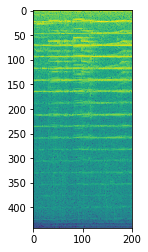

working
(442, 201)


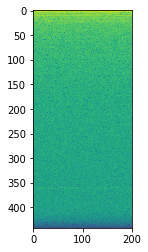

working
(442, 201)


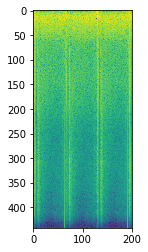

working
(442, 201)


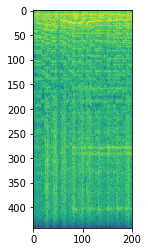

working
(442, 201)


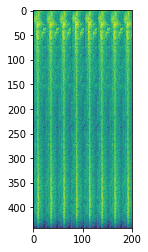

working
(442, 201)


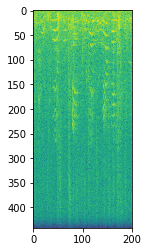

working
(442, 201)


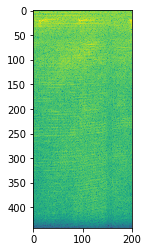

In [38]:
with tf.Session() as sess:    
    for i in range(20):
        SXX= sess.run(Sxx)
        plt.imshow(SXX[0])
        print(SXX[0].shape)
        plt.show()

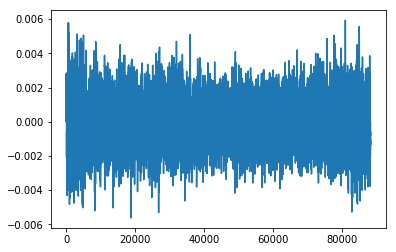

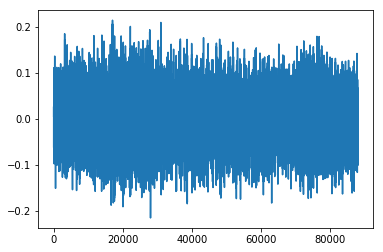

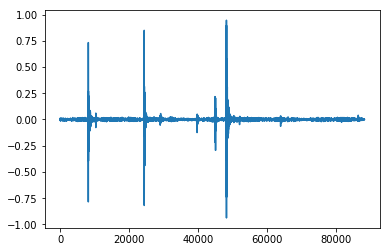

In [39]:
with tf.Session() as sess:    
    for i in range(3):
        Y, FS = sess.run([y, fs])
        plt.plot(Y)
        plt.show()